## Data preprocess

In [ ]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
import torch.optim as optim
import bs4
import urllib.request

webpage = str(urllib.request.urlopen("https://www.gutenberg.org/cache/epub/45839/pg45839.txt").read())
soup = bs4.BeautifulSoup(webpage)
text = soup.get_text()

text = text.replace("\\r\\n", '\n')


print(text[0:1000])

b'\xef\xbb\xbfThe Project Gutenberg eBook of Dracula
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Dracula

Author: Bram Stoker

Release date: May 30, 2014 [eBook #45839]
                Most recently updated: March 17, 2025

Language: English

Credits: Produced by Juliet Sutherland, Reiner Ruf, James Adcock
        and the Online Distributed Proofreading Team at
        http://www.pgdp.net


*** START OF THE PROJECT GUTENBERG EBOOK DRACULA ***

                          Transcriber\xe2\x80\x99s Note
                          ##################

This e-text is based on a reproduction

In [ ]:
print(text[50000:51000])

hunter.\xe2\x80\x9d Then he rose and said:--

\xe2\x80\x9cBut you must be tired. Your bedroom is all ready, and to-morrow you
shall sleep as late as you will. I have to be away till the afternoon;
so sleep well and dream well!\xe2\x80\x9d and, with a courteous bow, he opened for
me himself the door to the octagonal room, and I entered my bedroom....

I am all in a sea of wonders. I doubt; I fear; I think strange things
which I dare not confess to my own soul. God keep me, if only for the
sake of those dear to me!

_7 May._--It is again early morning, but I have rested and enjoyed the
last twenty-four hours. I slept till late in the day, and awoke of my
own accord. When I had dressed myself I went into the room where we had
supped, and found a cold breakfast laid out, with coffee kept hot by
the pot being placed on the hearth. There was a card on the table, on
which was written:--

\xe2\x80\x9cI have to be absent for a while. Do not wait for me.--D.\xe2\x80\x9d So I set to
and enjoyed a

In [ ]:
# Vocabulary
tokens = list(set(text))
print( tokens )

['e', 'g', '%', 'b', 'q', '*', 'l', '8', 'I', 'x', '5', 'j', '!', 'Q', '_', 'w', ')', '}', 'z', '.', ']', 'v', '3', 'M', 'k', '#', 'n', '0', '-', 'f', '\\', '2', 'O', 'h', 'D', ' ', '{', 't', 'S', '1', 'V', 'p', '/', 'd', 'J', 'a', "'", 'P', 'u', '4', '7', '9', 'G', '?', 'X', ':', 'U', 'Z', '$', 'i', 'Y', 'c', 'W', 'E', 'T', 'A', 'o', '[', 's', 'N', 'H', 'm', ',', 'K', 'r', '6', 'C', 'B', ';', 'F', '&', 'R', 'y', '(', '\n', 'L']


In [ ]:
len( tokens )

86

In [ ]:
def generate_sample_token_sequence(text, sequence_length):
  start_point = random.randint(0, len( text ) - 1 - sequence_length - 1)
  # We want to get a sequence of length 'length', and the next character
  substring = text[start_point:start_point + sequence_length]
  next_token = text[start_point + sequence_length]

  return substring, next_token

generate_sample_token_sequence(text, 100)

(' the ground, so as not to lose a chance. I went down\neven into the vaults, where the dim light strug',
 'g')

In [ ]:
def generate_batch(text, length, batch_size, token_dict):
  x_index_lists = []
  y_index_list = []

  for i in range( batch_size ):
    substring, next_token = generate_sample_token_sequence( text, length )
    x_index_lists.append( [ token_dict.index( c ) for c in substring ]  )
    y_index_list.append( token_dict.index( next_token ))

  return torch.LongTensor(x_index_lists), torch.LongTensor(y_index_list)

In [ ]:
generate_batch(text, length = 10, batch_size = 5, token_dict = tokens)

(tensor([[59, 26, 82, 28, 28, 68, 48,  3, 11,  0],
         [35, 45, 37, 35, 71,  0, 84,  1, 74, 45],
         [35, 33,  0, 35, 61, 45, 26, 35, 29, 45],
         [35, 64, 33,  0, 82, 35, 15,  0, 74,  0],
         [33,  0, 84, 68, 37,  0, 37, 33, 66, 68]]),
 tensor([61, 37, 37, 35, 61]))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Processing on:", device)

Processing on: cuda


## RNN

### architecture


In [ ]:
class TokenRNNModel(nn.Module):
  def __init__(self, token_dictionary, embedding_size):
    super(TokenRNNModel, self).__init__()

    self.tokens = token_dictionary
    self.embedding_dim = embedding_size

    self.embedding = nn.Embedding( len( self.tokens ), self.embedding_dim, max_norm=True)

    self.rnn = nn.RNN(
        input_size = self.embedding_dim,
        hidden_size = 3 * self.embedding_dim, # Setting this arbitrarily to 3 * the embedding dimension
        num_layers=1, # 1, since we aren't stacking any RNNs here
        bias=True,
        batch_first = True, # true this is just specifying which dimension has the batch info
        dropout=0.0,
        bidirectional=False)

    self.logits = nn.Linear(in_features = 3*self.embedding_dim, out_features = len( self.tokens ) )

  def forward(self, input_tensor): # input shape: batch_size, seq_len

    embedded = self.embedding( input_tensor ) # (batch, seq_len, emb_size)

    seq_output, last_states = self.rnn( embedded ) # last state (batch, 1, hidden)

    output = last_states[0]

    output = self.logits( output ) # output (batch, token_num)

    return output

What we have inside an RNN

\begin{align}
h_{i+1} &= \phi(w_{ih} \cdot x_i + w_{hh} \cdot h_i + b_{ih})\\
y_{i} &= \phi(w_{hr} \cdot h_{i+1} + b_{hh})
\end{align}

```python
w_ih = Parameter(
    torch.empty((hidden_size, layer_input_size), **factory_kwargs)
)
w_hh = Parameter(
    torch.empty((hidden_size, hidden_size), **factory_kwargs)
)
b_ih = Parameter(torch.empty(hidden_size, **factory_kwargs))
b_hh = Parameter( torch.empty(hidden_size, **factory_kwargs))
w_hr = Parameter(
    torch.empty((hidden_size, hidden_size), **factory_kwargs)
)
layer_params = (w_ih, w_hh, b_ih, b_hh, w_hr)
```

What we have inside a nn.Embedding:

```python
            self.weight = Parameter(
                torch.empty((num_embeddings, embedding_dim), **factory_kwargs),
                requires_grad=not _freeze,
            )
            self.reset_parameters()
```

In [ ]:
def predict_next_character(model, substring, tokens):
  indices = torch.LongTensor( [ [ tokens.index(c) for c in substring ] ] )
  indices = indices.to( device )
  next_token_logits = model( indices ).detach()[0]
  next_token_probabilities = torch.nn.Softmax( dim = 0 )( next_token_logits )
  next_token_probabilities = next_token_probabilities.to( 'cpu' )
  next_token_probabilities = np.asarray( next_token_probabilities )

  next_character = random.choices( tokens, weights = next_token_probabilities, k = 1 )
  return next_character[0]

def extend_prompt(model, prompt, tokens, character_count):
  model.eval()
  output = prompt
  with torch.no_grad():

    for i in range( character_count ):
      next_character = predict_next_character(model, output, tokens)
      output += next_character
  return output

In [ ]:
rnn_model = TokenRNNModel(tokens, embedding_size=30)
rnn_model = rnn_model.to( device )

In [ ]:
extend_prompt( rnn_model, "Dracula flew", tokens, character_count=30)

'Dracula flew5)!,)UD(KpgkF3TVRmL9WV]n%HSWd&'

In [ ]:
extend_prompt(rnn_model, "The Count", tokens, 100)

"The Countq#ixu%(bBM}$-oAOfxGv'03n?L(sJ]-UVtkw.0FOlRN!a.WjKiv$b2W$m7pUv0MeSF]G-eV.z!OBR3}M5'te_Xn/NF1/'zG!lB_u"

### training


In [ ]:
x_batch, y_batch = generate_batch(text, 10, 5, tokens)
x_batch = x_batch.to( device )
y_batch = y_batch.to( device )

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam( rnn_model.parameters(), lr = 0.01 )

rnn_loss_history = []
lstm_loss_history = []

In [ ]:
batch_size = 512

for epoch in range(10):
  total_loss = 0
  print("Training Epoch", epoch)
  print()

  rnn_model.train()

  for batch in range( 100 ):
    seq_length = random.randint(1,100)
    x_batch, y_batch =  generate_batch(text, seq_length, batch_size, tokens)
    x_batch = x_batch.to( device )
    y_batch = y_batch.to( device )
    optimizer.zero_grad()
    logits = rnn_model( x_batch )
    loss = loss_function( logits, y_batch )
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print("########################################################")
  print( extend_prompt(rnn_model, "The Count", tokens, 500) )
  print( total_loss / ( 100 ))
  rnn_loss_history.append(total_loss / ( 100 ))
  print("########################################################")

Training Epoch 0

########################################################
The Count
 ome and an\xe2\xring the foun fim cice
ap
efoler onleld an tiln\xe2\x98nd
wet IiwAsee epe ho\xa2\x9evi-leeEint It ar, wimo toon ris hong
fe fo tis wou bounconey
theotI, the hea s iud ow ters Iukcens
ot ow mee vof otvarath, ann theiting\s
aoy aultos nishee-ve9\x80\x9xe
hat menout heom tosiou\t Wimeveagiiv
romur
ho an hecof grtin bauwat yarping artena-R99s
fur whes
ave posiostind woule wolyelf herye Wing
hee brI lru-\xe2\x80\x9e
her.
Angn
8inoi-dar had me bupdar fue ant, becye;d bes idtimeleerir
2.751584153175354
########################################################
Training Epoch 1

########################################################
The Count of cyatroom misr\xe2\x80\x9d
ry agals o\xu2 nxanel, and cout lous, tomy, Iw
I hat wou :n her tanxeccow on ahecn noowlling hing daln maul, proor oren there re.
Shibs be bitime
in, afranald, ess of Houl su. 
Drome sidrid

aspsagr gof in ank o deim, Is thera

In [ ]:
for epoch in range(20):
  total_loss = 0

  rnn_model.train()

  for batch in range( 100 ):
    seq_length = random.randint(1,100)
    x_batch, y_batch =  generate_batch(text, seq_length, batch_size, tokens)
    x_batch = x_batch.to( device )
    y_batch = y_batch.to( device )
    optimizer.zero_grad()
    logits = rnn_model( x_batch )
    loss = loss_function( logits, y_batch )
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  epoch_loss = total_loss / ( 100 )
  print( "Training Epoch", epoch, "Loss - ", total_loss / ( 100 ))
  rnn_loss_history.append(epoch_loss)

Training Epoch 0 Loss -  1.8931433701515197
Training Epoch 1 Loss -  1.8911095643043518
Training Epoch 2 Loss -  1.8493975520133972
Training Epoch 3 Loss -  1.8548383808135986
Training Epoch 4 Loss -  1.8686649131774902
Training Epoch 5 Loss -  1.8481960821151733
Training Epoch 6 Loss -  1.8360322868824006
Training Epoch 7 Loss -  1.8195323967933654
Training Epoch 8 Loss -  1.8288768219947815
Training Epoch 9 Loss -  1.8076302409172058
Training Epoch 10 Loss -  1.8098558402061462
Training Epoch 11 Loss -  1.8188288295269013
Training Epoch 12 Loss -  1.8174109494686126
Training Epoch 13 Loss -  1.804020218849182
Training Epoch 14 Loss -  1.8084099292755127
Training Epoch 15 Loss -  1.8071382308006287
Training Epoch 16 Loss -  1.784850491285324
Training Epoch 17 Loss -  1.772410957813263
Training Epoch 18 Loss -  1.7666689026355744
Training Epoch 19 Loss -  1.7839884638786316


In [ ]:
print( extend_prompt(rnn_model, "The Count", tokens, 500) )

The Count
with bshens, mare is is. Brase hes festains tain net; and gvian as the diesed to when any to the wace her and all they yes helsarbed me in the did healling-- 
            
    My
yeppess a A foerar, had not quitesalf veared meed, eagep, I fareed tearnef, whiched and knef while chut unching sreabess over
and was face\xe2\x80\x9cYeem
and cant all, and me.

We oret may of eed, lays\xe2\x80\x9c.25 Jours dying so to ques in my kelvicct the woald is sessynod, and withouting was me. In
whice purcom hi


## LSTM from scratch


In [ ]:
import torch
from typing import List, Tuple, Optional

def _unpack_flat_weights(
    flat_weights, num_layers, bidirectional, bias
):
    weights = []
    idx = 0
    num_directions = 2 if bidirectional else 1
    for _ in range(num_layers):
        layer_w = []
        for _ in range(num_directions):
            W_ih = flat_weights[idx]; idx += 1  # shape: (52, 11) = (4*hidden_size, input_size)
            W_hh = flat_weights[idx]; idx += 1  # shape: (52, 13) = (4*hidden_size, hidden_size)
            if bias:
                b_ih = flat_weights[idx]; idx += 1  # shape: (52,)
                b_hh = flat_weights[idx]; idx += 1  # shape: (52,)
            else:
                b_ih = None
                b_hh = None
            layer_w.append((W_ih, W_hh, b_ih, b_hh))
        weights.append(layer_w)

    # list of length num_layers,
    # each item is list of length num_directions,
    # each item is tuple of 4 tensors
    return weights


def _lstm_cell(
    x: torch.Tensor,
    h: torch.Tensor,
    c: torch.Tensor,
    W_ih: torch.Tensor,
    W_hh: torch.Tensor,
    b_ih: Optional[torch.Tensor],
    b_hh: Optional[torch.Tensor],
) -> Tuple[torch.Tensor, torch.Tensor]:
    # gates: [batch, 4*hidden_size]
    gates = x @ W_ih.t() + h @ W_hh.t()
    if b_ih is not None: gates = gates + b_ih
    if b_hh is not None: gates = gates + b_hh
    i, f, g, o = gates.chunk(4, dim=1)
    i = torch.sigmoid(i) # input
    f = torch.sigmoid(f) # forget
    g = torch.tanh(g) # candidate
    o = torch.sigmoid(o) # output
    c_next = f * c + i * g
    h_next = o * torch.tanh(c_next)
    return h_next, c_next

def lstm_pure(input,
              batch_sizes,
              hx,
              flat_weights,
              bias,
              num_layers,
              dropout,
              training,
              bidirectional):
    assert batch_sizes is None, "Packed sequences not supported in this minimal impl."
    assert input.dim() == 3
    seq_len, batch, _ = input.shape
    num_directions = 2 if bidirectional else 1

    weights = _unpack_flat_weights(flat_weights, num_layers, bidirectional, bias)
    hidden_size = weights[0][0][1].shape[1]

    if hx is None:
        h0 = input.new_zeros((num_layers * num_directions, batch, hidden_size))
        c0 = input.new_zeros((num_layers * num_directions, batch, hidden_size))
    else:
        h0, c0 = hx

    # Handle zero-length input like PyTorch: output is empty, hn/cn = h0/c0
    if seq_len == 0:
        output = input.new_zeros((0, batch, hidden_size * num_directions))
        return output, (h0.clone(), c0.clone())

    layer_input = input
    final_h = []
    final_c = []

    for layer in range(num_layers):
        layer_out_fwd = []
        layer_out_bwd = []

        h_layer = h0[layer*num_directions:(layer+1)*num_directions]
        c_layer = c0[layer*num_directions:(layer+1)*num_directions]

        # Forward direction
        W_ih_f, W_hh_f, b_ih_f, b_hh_f = weights[layer][0]
        h_t = h_layer[0]; c_t = c_layer[0]
        for t in range(seq_len):
            x_t = layer_input[t]
            h_t, c_t = _lstm_cell(x_t, h_t, c_t, W_ih_f, W_hh_f, b_ih_f, b_hh_f)
            layer_out_fwd.append(h_t)  # <-- always append
        final_h_f = h_t
        final_c_f = c_t

        # Backward direction (if any)
        if bidirectional:
            W_ih_b, W_hh_b, b_ih_b, b_hh_b = weights[layer][1]
            hb_t = h_layer[1]; cb_t = c_layer[1]
            for t in reversed(range(seq_len)):
                x_t = layer_input[t]
                hb_t, cb_t = _lstm_cell(x_t, hb_t, cb_t, W_ih_b, W_hh_b, b_ih_b, b_hh_b)
                layer_out_bwd.append(hb_t)
            layer_out_bwd.reverse()
            final_h_b = hb_t
            final_c_b = cb_t

        # Collect
        if bidirectional:
            layer_output = torch.cat(
                [torch.stack(layer_out_fwd, dim=0), torch.stack(layer_out_bwd, dim=0)],
                dim=2
            )
            final_h.extend([final_h_f, final_h_b])
            final_c.extend([final_c_f, final_c_b])
        else:
            layer_output = torch.stack(layer_out_fwd, dim=0)
            final_h.append(final_h_f)
            final_c.append(final_c_f)

        if training and dropout and layer < num_layers - 1:
            layer_output = torch.nn.functional.dropout(layer_output, p=dropout, training=True)

        layer_input = layer_output

    output = layer_input
    hn = torch.stack(final_h, dim=0)
    cn = torch.stack(final_c, dim=0)
    return output, (hn, cn)


# ------------------------------------------------------------
# quick smoke test comparing with nn.LSTM on the same weights
if __name__ == "__main__":
    torch.manual_seed(0)
    T = 7 # seq len
    B = 1 # batch size
    I = 11 # input size
    H = 13 # hidden size
    L = 5 # num layers
    bidir = True
    lstm = torch.nn.LSTM(I, H, L, bidirectional=bidir, bias=True, dropout=0.0, batch_first=False)
    x = torch.randn(T, B, I)
    h0 = torch.randn(L*(2 if bidir else 1), B, H)
    c0 = torch.randn(L*(2 if bidir else 1), B, H)

    # collect flat weights in the same order nn.LSTM uses internally
    fw = []
    for l in range(L): # iterate layers
        # forward
        fw += [getattr(lstm, f'weight_ih_l{l}'),
               getattr(lstm, f'weight_hh_l{l}'),
               getattr(lstm, f'bias_ih_l{l}'),
               getattr(lstm, f'bias_hh_l{l}')]
        if bidir:
            fw += [getattr(lstm, f'weight_ih_l{l}_reverse'),
                   getattr(lstm, f'weight_hh_l{l}_reverse'),
                   getattr(lstm, f'bias_ih_l{l}_reverse'),
                   getattr(lstm, f'bias_hh_l{l}_reverse')]

    y_ref, (hn_ref, cn_ref) = lstm(x, (h0, c0))
    y_min, (hn_min, cn_min) = lstm_pure(
        x,
        None,
        hx=(h0, c0),
        flat_weights=fw,
        bias=True,
        num_layers=L,
        dropout=0.0,
        training=True,
        bidirectional=bidir)

    # they should be (almost) identical
    print((y_ref - y_min).abs().max().item(),
          (hn_ref - hn_min).abs().max().item(),
          (cn_ref - cn_min).abs().max().item())


5.960464477539063e-08 5.960464477539063e-08 8.940696716308594e-08


## LSTM

In [ ]:
class TokenLSTMModel(nn.Module):
  def __init__(self, token_dictionary, embedding_size):
    super().__init__()

    self.tokens = token_dictionary
    self.embedding_dim = embedding_size

    self.embedding = nn.Embedding( len( self.tokens ), self.embedding_dim, max_norm=True)

    self.lstm = nn.LSTM(
        input_size = self.embedding_dim,
        hidden_size = 3 * self.embedding_dim, # arbitrary H
        num_layers=4,
        bias=True,
        batch_first = True,
        dropout=0.1,
        bidirectional=True)

    self.logits = nn.Linear(
        in_features = 3*self.embedding_dim*2,
        out_features = len( self.tokens )
        )

  def forward(self, input_tensor): # (B, seq_len)

    embedded = self.embedding( input_tensor ) # (B, seq_len, emb_dim)

    seq_output, (final_state_vectors, final_cell_vectors)  = self.lstm( embedded ) # (B, seq, 2H), (lyr*dir, B, H), (lyr*dir,B,H)

    lstm_output = seq_output[:, -1, :]

    output = self.logits( lstm_output )

    return output

\begin{array}{ll} \\
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
            c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
            h_t = o_t \odot \tanh(c_t) \\
        \end{array}

In [ ]:
lstm_model = TokenLSTMModel(tokens, 30)
lstm_model = lstm_model.to( device )
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam( lstm_model.parameters(), lr = 0.01 )

In [ ]:
for epoch in range(20):
  total_loss = 0
  lstm_model.train()

  for batch in range( 100 ):
    seq_length = random.randint(1,100)
    x_batch, y_batch =  generate_batch(text, seq_length, batch_size, tokens)
    x_batch = x_batch.to( device )
    y_batch = y_batch.to( device )
    optimizer.zero_grad()
    logits = lstm_model( x_batch )
    loss = loss_function( logits, y_batch )
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  epoch_loss = total_loss / ( 100 )
  print( "Training Epoch", epoch, "Loss - ", total_loss / ( 100 ))
  lstm_loss_history.append(epoch_loss)

Training Epoch 0 Loss -  3.143465931415558
Training Epoch 1 Loss -  2.6646463561058042
Training Epoch 2 Loss -  2.4500205945968627
Training Epoch 3 Loss -  2.300137176513672
Training Epoch 4 Loss -  2.2010260105133055
Training Epoch 5 Loss -  2.113017053604126
Training Epoch 6 Loss -  2.0394779098033906
Training Epoch 7 Loss -  2.017603942155838
Training Epoch 8 Loss -  1.974089995622635
Training Epoch 9 Loss -  1.944562659263611
Training Epoch 10 Loss -  1.8850549232959748
Training Epoch 11 Loss -  1.845703216791153
Training Epoch 12 Loss -  1.8514897882938386
Training Epoch 13 Loss -  1.8193698930740356
Training Epoch 14 Loss -  1.810321751832962
Training Epoch 15 Loss -  1.806280528306961
Training Epoch 16 Loss -  1.773234417438507
Training Epoch 17 Loss -  1.7398565876483918
Training Epoch 18 Loss -  1.7408306920528411
Training Epoch 19 Loss -  1.7393998146057128


In [ ]:
for epoch in range(20):
  total_loss = 0
  lstm_model.train()

  for batch in range( 100 ):
    seq_length = random.randint(1,100)
    x_batch, y_batch =  generate_batch(text, seq_length, batch_size, tokens)
    x_batch = x_batch.to( device )
    y_batch = y_batch.to( device )
    optimizer.zero_grad()
    logits = lstm_model( x_batch )
    loss = loss_function( logits, y_batch )
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  epoch_loss = total_loss / ( 100 )
  print( "Training Epoch", epoch, "Loss - ", total_loss / ( 100 ))
  lstm_loss_history.append(epoch_loss)

Training Epoch 0 Loss -  1.7189557087421417
Training Epoch 1 Loss -  1.7119332194328307
Training Epoch 2 Loss -  1.6957061612606048
Training Epoch 3 Loss -  1.7212043046951293
Training Epoch 4 Loss -  1.7066903698444367
Training Epoch 5 Loss -  1.6922927165031434
Training Epoch 6 Loss -  1.678014144897461
Training Epoch 7 Loss -  1.6606963276863098
Training Epoch 8 Loss -  1.6474368250370026
Training Epoch 9 Loss -  1.6576394259929657
Training Epoch 10 Loss -  1.615217535495758
Training Epoch 11 Loss -  1.6415189445018767
Training Epoch 12 Loss -  1.646038656234741
Training Epoch 13 Loss -  1.6368102848529815
Training Epoch 14 Loss -  1.630885239839554
Training Epoch 15 Loss -  1.608178560733795
Training Epoch 16 Loss -  1.6330115985870362
Training Epoch 17 Loss -  1.6314755547046662
Training Epoch 18 Loss -  1.6036027264595032
Training Epoch 19 Loss -  1.5933538448810578


In [ ]:
print( extend_prompt(lstm_model, "The Count", tokens, 500) )

The Count wand they bou with the prelunce from
if_ No
baught
me the room wakenes thing Pissols. Susiness so this betters. Is me; now:               # Drans his desirely resilt, whites in eyesing
of how myself ounly\xe2\x80\x9d

\xe2\x80\x99clucy; mayI, write, enter-Her
lordfare, and mosiencriding. Youled koluty. We chain
on
there is shallges!\xe2\x80\x9cLooked a
gos, with she eyesd more understor for he seeeriant, ded Stills unrox, grein, A bair, with an see and
as the sopcusing open; stors Hose to must 


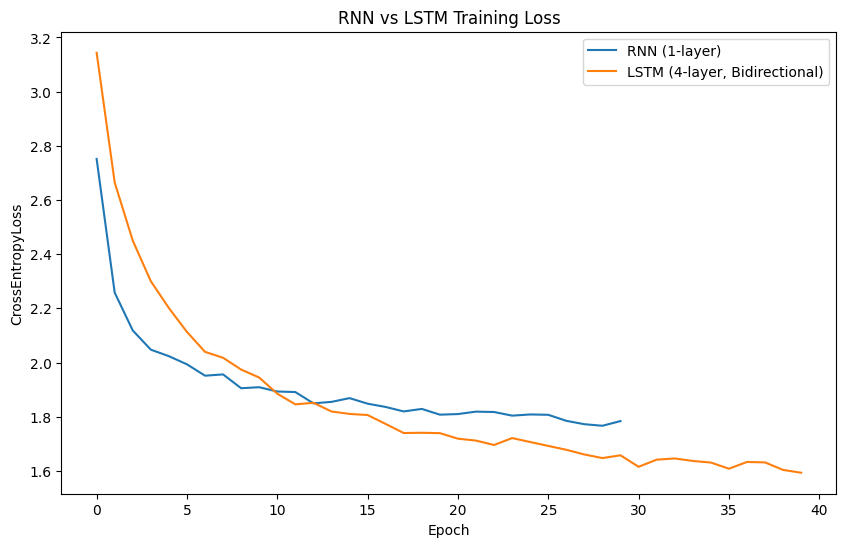

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rnn_loss_history, label="RNN (1-layer)")
plt.plot(lstm_loss_history, label="LSTM (4-layer, Bidirectional)")
plt.title("RNN vs LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropyLoss")
plt.legend()
plt.show()

# Final Project

Method A: The 'Naive' Numeric Encoding
Board Numeric Representation (Numpy Array):
[[-1 -1 -1 -1 -1]
 [-1  1  1  1 -1]
 [-1  1  0  1 -1]
 [-1  2  2  2 -1]
 [-1 -1 -1 -1 -1]]


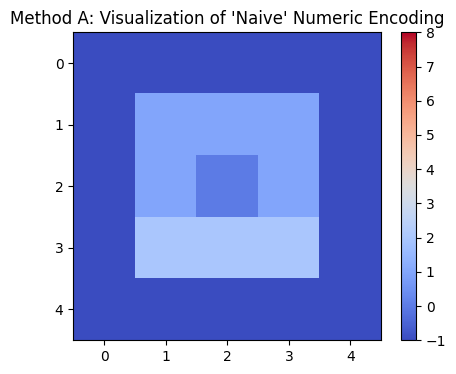

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

print("Method A: The 'Naive' Numeric Encoding")

# 1. Define a 'fake' Minesweeper board state.
# We use -1 for 'Hidden' and 0-8 for revealed clue numbers.
board_state_numeric = np.array([
    [-1, -1, -1, -1, -1],
    [-1,  1,  1,  1, -1],
    [-1,  1,  0,  1, -1], # The '0' is numerically between -1 and 1
    [-1,  2,  2,  2, -1],
    [-1, -1, -1, -1, -1]
])

print("Board Numeric Representation (Numpy Array):")
print(board_state_numeric)

# 2. Visualize the numeric data
plt.figure(figsize=(5, 4))
# Use a colormap to show the numeric values
plt.imshow(board_state_numeric, cmap='coolwarm', vmin=-1, vmax=8)
plt.colorbar(ticks=range(-1, 9))
plt.title("Method A: Visualization of 'Naive' Numeric Encoding")
plt.show()

In [ ]:
print("\nMethod B: The 'Embedding' Encoding")

# 1. Define a 'Vocabulary', just like in the Dracula text demo.
# We will skip 'Boundary' for simplicity, as suggested.
MS_VOCAB = ['HIDDEN', '0', '1', '2', '3', '4', '5', '6', '7', '8']
VOCAB_SIZE = len(MS_VOCAB)

# 2. Create a 'tokenized' board using the *indices* of our vocabulary.
# 'HIDDEN' -> 0
# '0'      -> 1
# '1'      -> 2
# '2'      -> 3
# ...
board_state_tokenized = np.array([
    [0, 0, 0, 0, 0],  # 'HIDDEN'
    [0, 2, 2, 2, 0],  # '1'
    [0, 2, 1, 2, 0],  # '0'
    [0, 3, 3, 3, 0],  # '2'
    [0, 0, 0, 0, 0]   # 'HIDDEN'
])

# 3. Convert to the LongTensor that PyTorch embedding layers expect.
board_tensor = torch.LongTensor(board_state_tokenized)

print(f"Our Vocabulary: {MS_VOCAB}")
print(f"Vocabulary Size: {VOCAB_SIZE}")
print("\n'Tokenized' Board (Tensor of Indices):")
print(board_tensor)


Method B: The 'Embedding' Encoding
Our Vocabulary: ['HIDDEN', '0', '1', '2', '3', '4', '5', '6', '7', '8']
Vocabulary Size: 10

'Tokenized' Board (Tensor of Indices):
tensor([[0, 0, 0, 0, 0],
        [0, 2, 2, 2, 0],
        [0, 2, 1, 2, 0],
        [0, 3, 3, 3, 0],
        [0, 0, 0, 0, 0]])


In [ ]:
# 4. This is the core idea: nn.Embedding.
# Just like the nn.Embedding(len(tokens), ...) in the Dracula demo.
EMBEDDING_DIM = 5  # We can pick any dimension (e.g., 5)
embedding_layer = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM)

# 5. Pass the 'tokenized' board through the embedding layer.
# This operation is just a lookup.
embedded_board = embedding_layer(board_tensor)

print(f"\nInput Board Shape (H, W): {board_tensor.shape}")
print(f"Output 'Embedded' Board Shape (H, W, EmbDim): {embedded_board.shape}")

# 6. How to feed this to a CNN?
# A CNN expects (Batch, Channels, H, W).
# We can 'permute' the dimensions to treat the Embedding Dim as 'Channels'.
# (Adding a batch dim of 1 for demo)
cnn_input = embedded_board.permute(2, 0, 1).unsqueeze(0)
print(f"\nShape ready for a CNN (B, C, H, W): {cnn_input.shape}")
print(f"(This directly answers 'How are you representing your input?' )")


Input Board Shape (H, W): torch.Size([5, 5])
Output 'Embedded' Board Shape (H, W, EmbDim): torch.Size([5, 5, 5])

Shape ready for a CNN (B, C, H, W): torch.Size([1, 5, 5, 5])
(This directly answers 'How are you representing your input?' )



Visualizing the Embedding Vectors


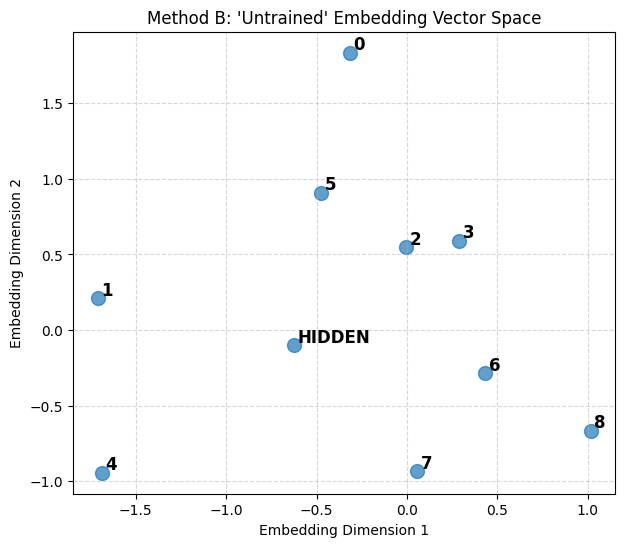

In [ ]:
print("\nVisualizing the Embedding Vectors")

embedding_2d = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=2)

untrained_vectors = embedding_2d.weight.data.numpy()

plt.figure(figsize=(7, 6))
plt.scatter(untrained_vectors[:, 0], untrained_vectors[:, 1], alpha=0.7, s=100)

for i, token in enumerate(MS_VOCAB):
    plt.annotate(token, (untrained_vectors[i, 0]+0.02, untrained_vectors[i, 1]+0.02), fontsize=12, fontweight='bold')

plt.title("Method B: 'Untrained' Embedding Vector Space")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()